# Data science Project

## Intro

In this project we going to explor data about ELAL's flight history.
The perpose is to explor if we can to predict if ELAL's flight will delayd or canceld



### Imports

In [395]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import seaborn as sns
import os
import time
from dateutil.relativedelta import relativedelta, MO
from dateutil.easter import easter
import jewish
import calendar
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline  
# Credit to https://github.com/emosenkis/jewish/blob/master/LICENSE

### Const Varibles

In [396]:
BASE_URL='https://api.flightstats.com/flex/flightstatus/historical/rest/v3/json/'


# APP_KEY='1073eea843b49ef65cd3dedce57340e0'
# APP_ID='a55ccedd'

# APP_KEY='9981b617cba5bb3f32d90ba0da4e2af4'
# APP_ID='65c679ae'

# APP_KEY= '9fb822148287f2805212cc61c199d8f8'
# APP_ID = 'd7585437'

# APP_KEY = 'eca188e5f3d730ee5d28907112889342'
# APP_ID = '4176580c'

APP_KEY = '37512902d28a8deac5ec0325e9f40a56'
APP_ID = 'bfeb4319'

ElAl_AIRCRAFTS_WEB_URL = 'https://www.elal.com/heb/about-elal/our-fleet/all-aircraft'
FLIGHTEAR_Base_URL = 'https://www.flightera.net/en/planes/'

AIRCRAFTS_DATA_FILE = 'aircrafts.json'
FLIGHT_Data_FILE = 'flights_data.json'
FLIGHTS_SCAN_METADATA_FILE = 'flights_scan_metadata.json'

TAIL_NUMBER_FEILD_NAME = 'tail_number'
FIRST_FLIGHT_DATE_FEILD_NAME = 'first_flight_date'
LAST_FLIGHT_DATE_FEILD_NAME = 'last-flight_date'
SEATS_FEILD_NAME = 'seats'
LAST_SCANNED__DATE_FEILD_NAME = 'last_scanned_date'


## General files and json functions

Functions that store and loads data from files

In [397]:
def store_object_to_file(file_name,data):
    with open(file_name, 'w') as outfile:
        json.dump(data, outfile)

In [398]:
def load_object_from_file(filename):
    if(not os.path.exists(filename)):
        return None
    with open(filename) as f:
        return json.load(f)

In [399]:
def store_data_to_aircrafts_file(tailnumber,feild_name,data):
    aircrafts_list = load_object_from_file(AIRCRAFTS_DATA_FILE)
    if(not aircrafts_list):
        aircrafts_list = []
    for i,aircraft in enumerate(aircrafts_list):
        if(tailnumber == aircraft[TAIL_NUMBER_FEILD_NAME]):
            aircrafts_list[i][feild_name] = data
            store_object_to_file(AIRCRAFTS_DATA_FILE,aircrafts_list)
            return

In [400]:
def load_data_from_aircrafts_file(tailnumber,feild_name):
    if(not os.path.exists(AIRCRAFTS_DATA_FILE)):
        return None
    aircrafts_list = load_object_from_file(AIRCRAFTS_DATA_FILE)
    for aircraft in aircrafts_list:
        if(tailnumber == aircraft[TAIL_NUMBER_FEILD_NAME]):
            if feild_name in aircraft:
                return aircraft[feild_name]
            else:
                return None

## Dates and holidays calculations

Mounths dictianery used to translate month name to numbrr

In [401]:
months = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }


Check if some date is crestian holiday

In [402]:
def is_christian_holiday(date):
    easter_date = easter(date.year)
    easter_sunday = datetime.strptime(easter_date.strftime('%m/%d/%Y'), '%m/%d/%Y').date()
    easter_monday = easter_sunday + relativedelta(weekday=MO)
    good_friday = easter_sunday - relativedelta(days=2)
    christmas_day = datetime(year=date.year, month=12, day=25).date()
    holidays = [easter_sunday, easter_monday, good_friday, christmas_day]
    return int(date in holidays)

In [403]:
def is_jewish_holiday(date):
    jewish_date = jewish.JewishDate.from_date(date)

    #rosh hashana
    if(jewish_date.day == 1 and jewish_date.month == 1): return 1
    #yom kipur
    if(jewish_date.day == 10 and jewish_date.month == 1): return 1
    #sukot
    if(jewish_date.month == 1 and (jewish_date.day >= 16 and jewish_date.day <= 21)): return 1
    #hanuka
    if(jewish_date.month == 3 and (jewish_date.day >= 23 and jewish_date.day <= 29)): return 1
    #passover
    if(jewish_date.month == 7 and (jewish_date.day >= 14 and jewish_date.day <= 22)): return 1

    return 0



### API functions

In [404]:
# "BASE URL + flight/status/tailNumber/4x-ELA/2015/1/1?appId=b1aa7a60&appKey=ed14bb251c167a18733cccbf86105175"

def get_Flight_by_date_and_tail_number(date,tail_number, days_per_request):
    formatted_date = date.strftime("%Y/%m/%d")

    #URL = BASE_URL + 'flight/status/tailNumber/' + tail_number + '/' + formatted_date + '?appId=' + APP_KEY + '&appKey=' + API_KEY
    URL = BASE_URL+'flight/status/tailNumber/'+tail_number+'/'+formatted_date+'?appId='+APP_ID+'&appKey='+APP_KEY+'&numDays=30'#+str(days_per_request)
    response = requests.get(URL)
    json_res =  response.json()
    if 'flightStatuses' in json_res: return json_res['flightStatuses'] , None
    if('error' in json_res): return None , json_res['error']
    return None, json_res[0]


test the api

In [405]:
# res = get_Flight_by_date_and_tail_number(datetime(2017,9,28),'4X-EDA',days_per_request=30)
# res

## Get information that we need before start to send api requests

To send this API request we have to know the aircradt tail number
we will get this informaition from elal web side via crouling

In [406]:
elal_web_res = requests.get(ElAl_AIRCRAFTS_WEB_URL)

In [407]:

elal_soup = BeautifulSoup(elal_web_res.content)

Define functios that clean the data


The format of right israeli tail number is '4X-' and 3 letters
like: '$X-ABC'

In [408]:
def clean_tail_numberst(tail_number):
    tail_number = tail_number.upper()
    first_instance_of_4x = tail_number.find('4X-')
    new_tail_number = tail_number[first_instance_of_4x:first_instance_of_4x+6]
    return new_tail_number



In [409]:
def clean_aircraft_name(name):
    return str(name.replace('\u200b',''))

In [410]:
def clean_model(model):
    model = model.strip()
    return model[3:]

Define function that return list of aircraft with ther usefull data

In [411]:
def get_basic_aircrafts_data_list():
    if(os.path.exists(AIRCRAFTS_DATA_FILE)):
        return load_object_from_file(AIRCRAFTS_DATA_FILE)
    
    aircrafts_list=[]
    tables_list = elal_soup.find_all('tbody')
    headers_list = elal_soup.find_all('span',class_ = 'mat-content')
    for j,table in enumerate(tables_list):
        rows_list = table.findAll('tr')
        for row in rows_list[1:]:
            cells_list = row.findAll('td')
            for i,cell in enumerate(cells_list[1::2]):
                aircraft_object = {}
                aircraft_object['tail_number'] = clean_tail_numberst(cell.get_text())
                aircraft_object['model'] = clean_model(headers_list[j].get_text())
                aircraft_object['name'] = clean_aircraft_name(cells_list[i].get_text())
                aircrafts_list.append(aircraft_object) 

    if (not os.path.exists(AIRCRAFTS_DATA_FILE)):
        store_object_to_file(AIRCRAFTS_DATA_FILE,aircrafts_list)   
    return aircrafts_list

#basic_data



### Get more Advanced information about aircraft that not exost in ELAL website 

this dictianery store soap object about each aircraft
it use to lower the http get request to flightera website becaue it will block us if we try to request each time we want more information about the same aircraft

In [412]:
flightEra_soaps_dict = {}

Define function that get flightera soap object of spesific air craft

if we also have soap object about this aircraft in the dict we just need to return it
else, we create http request, convert it to soap object and store it to the dist. then return it

In [413]:
def get_flghtera_soap_by_tail_number(tail_number): 
    if (tail_number.lower() not in flightEra_soaps_dict):       
        URL = FLIGHTEAR_Base_URL + tail_number
        flightera_response = requests.get(URL)
        if (not flightera_response.status_code == 200):
            print('Error resived data about '+tail_number+' from FLightera web sit, error code: ' + str(flightera_response.status_code))
            return None
        flightEra_soaps_dict[tail_number] =  BeautifulSoup(flightera_response.content)
    
    return flightEra_soaps_dict[tail_number]

In [414]:
x = get_flghtera_soap_by_tail_number('4x-elk')
x

Error resived data about 4x-elk from FLightera web sit, error code: 403


## Get first  and last filght date

we neet to get the first time that specific aircrat fly.
this information help us to reduse the api request we need to do because eithout it we will need to create requests for evwry day in pre known dates range and if we know the first and last flights date of the aircraft we can short the dates range

### Get first flight date

In [415]:
def get_first_flight_date_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,FIRST_FLIGHT_DATE_FEILD_NAME)

In [416]:
def store_first_flight_date_data(tail_number,first_flight_date):
    store_data_to_aircrafts_file(tail_number,FIRST_FLIGHT_DATE_FEILD_NAME,first_flight_date)

In [417]:
def clean_first_flight_dtate_string(date_str):
    clean_str = date_str.replace('\n', '')
    clean_str = clean_str.strip()
    clean_str = clean_str[:clean_str.find('(')]
    clean_str = clean_str.strip()
    return clean_str

In [418]:
def convert_daytime_to_dict(date):
    if (date == None):
         return None
    return {
        'year' : date.year,
        'month' : date.month,
        'day' : date.day
    }

In [419]:
def get_first_flight_date_by_crowling(tail_number):
    aircraft_soap = get_flghtera_soap_by_tail_number(tail_number.lower())
    if(not aircraft_soap): 
        return None
    try:
        for td in aircraft_soap.find_all('td'):
            if(td.get_text().find('years ago') != -1):
                date_string = td.get_text()
        date_string = clean_first_flight_dtate_string(date_string)
        month , year = date_string.split(' ')
        return convert_daytime_to_dict(datetime(int(year),int(months[month.lower()]),27))
    except:
        return None
    return None

In [420]:
def get_first_flight_date_by_tailnnumber(tail_number):
    cashed_data = get_first_flight_date_from_Cache(tail_number)
    
    if(cashed_data):
        return cashed_data
    else: 
        first_flight_date_data = get_first_flight_date_by_crowling(tail_number)
        if(first_flight_date_data):
            store_first_flight_date_data(tail_number,first_flight_date_data)
            return first_flight_date_data
        return None

### Get Last flight date

In [421]:
def get_last_flight_date_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,LAST_FLIGHT_DATE_FEILD_NAME)

In [422]:
def store_last_flight_date_data(tail_number,last_flight_date):
    store_data_to_aircrafts_file(tail_number,LAST_FLIGHT_DATE_FEILD_NAME,last_flight_date)

In [423]:
def clean_last_flight_month(mnt):
    mnt = mnt.replace('\t','')
    mnt = mnt.strip()
    mnt = mnt[:3]
    return mnt.lower()

In [424]:
def get_last_flight_date_by_crowling(tail_number):
    aircraft_soap = get_flghtera_soap_by_tail_number(tail_number.lower())
    if(not aircraft_soap): return None
    try:
        year = int(aircraft_soap.find('body').find_all('div',class_='sm:px-6')[4].find_all('dt')[0].get_text())
        month = aircraft_soap.find('body').find_all('div',class_='sm:px-6')[4].find_all('dl')[0].find_all('dd')[0].find_all('div')[0].get_text()
        month = clean_last_flight_month(month)
        
        last_flight_date = datetime(year,months[month],1)
        return convert_daytime_to_dict(last_flight_date)
    except:
        return None
    return None

In [425]:
def get_last_flight_date_by_tailnnumber(tail_number):
    cashed_data = get_last_flight_date_from_Cache(tail_number)
    if(cashed_data): return cashed_data
    else: 
        last_flight_date_data = get_last_flight_date_by_crowling(tail_number)
        if(last_flight_date_data):
            store_last_flight_date_data(tail_number,last_flight_date_data)
            return last_flight_date_data
        return None

## Get number of seats per aircraft

this information can be usefull to predict the dilay time of flight

In [426]:
def store_seats_data(tail_number,seats_object):
    store_data_to_aircrafts_file(tail_number,SEATS_FEILD_NAME,seats_object)

In [427]:
def get_seats_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,SEATS_FEILD_NAME)

In [428]:
def get_seats_by_crowling(tail_number):
    aircraft_soap = get_flghtera_soap_by_tail_number(tail_number.lower())
    aircraft_seat_object = {}
    strings = []
    try:
        for td in aircraft_soap.find_all('td'):
            if(td.get_text().find('seats') != -1):
                strings = td.get_text().split('\n')
                
    except:
        return None
    i=0
    for i,s in enumerate(strings):
        if(s.find('seats') != -1):
            break
    for content in strings[i+1:-1]:
        seat , class_ = content.split(' ')
        aircraft_seat_object[class_] = str(seat)
        print(aircraft_seat_object)

    return aircraft_seat_object
    

In [429]:
def get_seats_by_tail_number(tail_number):
    cashed_data = get_seats_from_Cache(tail_number)
    if(cashed_data): return cashed_data
    else: 
        seats_data = get_seats_by_crowling(tail_number)
        if(seats_data):
            store_seats_data(tail_number,seats_data)
            return seats_data
        return None
        

### Last scanned date

we store the last scanned date,
this date is the last date from all the days this air craft was active that we know the flight history of.

for example if the aircraft is active from 1/1/2017 untill today and last scanned date is 1/3/2017 it's mean we have all the flights of this aircraft from 1/1/2017 to 1/3/2017.

this information help us to avoid duplicate flights in our dataset and minimize the number of api requests

In [430]:
def get_last_scanned_date_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,LAST_SCANNED__DATE_FEILD_NAME)
    

In [431]:
def get_last_scanned_date_of_aircraft(tail_number):
    cashed_data = get_last_scanned_date_from_Cache(tail_number)
    if(cashed_data): return cashed_data
    else: 
        last_scanned_date = load_data_from_aircrafts_file(tail_number,FIRST_FLIGHT_DATE_FEILD_NAME) 
        if(last_scanned_date):
            store_data_to_aircrafts_file(tail_number,LAST_SCANNED__DATE_FEILD_NAME,last_scanned_date)
            return last_scanned_date
        return None

## Put all this data togeter

Define function that get advanced information about eace air crafr
this function call to every function that can add information about spesific aircraft

In [432]:
def get_aircrafts_full_information():
    if (os.path.exists(AIRCRAFTS_DATA_FILE)):
        return load_object_from_file(AIRCRAFTS_DATA_FILE)
    
    aircrafts_list = get_basic_aircrafts_data_list()
    for aircraft in aircrafts_list:
        #Add first flight date information
        first_flght_date_data = get_first_flight_date_by_tailnnumber(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(first_flght_date_data):
            aircraft[FIRST_FLIGHT_DATE_FEILD_NAME] = first_flght_date_data

        #Add last flight date information
        last_flght_date_data = get_last_flight_date_by_tailnnumber(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(last_flght_date_data):
            aircraft[LAST_FLIGHT_DATE_FEILD_NAME] = last_flght_date_data

        #Add seats to airplanes data
        seats_data = get_seats_by_tail_number(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(seats_data):
            aircraft[SEATS_FEILD_NAME] = seats_data
        
        last_scanned_daate = get_last_scanned_date_of_aircraft(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(last_scanned_daate):
            aircraft[LAST_SCANNED__DATE_FEILD_NAME] = last_scanned_daate


    store_object_to_file(AIRCRAFTS_DATA_FILE,aircrafts_list)
    return aircrafts_list


We will add one more feild to the aircraft data that contain the last data that the API Checked

## Preview our aircrafts data

In [433]:
def get_airrcrafts_data_as_dataframe():
    aircrafts_list = get_aircrafts_full_information()
    df = pd.DataFrame(aircrafts_list)
    return df
aircrafts_df = get_airrcrafts_data_as_dataframe()
aircrafts_df

,tail_number,model,name,first_flight_date,last-flight_date,seats,last_scanned_date
0,4X-EKH,737-800,חדרה,"{'year': 2009, 'month': 4, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 6, 'day': 24}"
1,4X-EKJ,737-800,דגניה,"{'year': 2009, 'month': 5, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 9, 'day': 26}"
2,4X-EKL,737-800,נהלל,"{'year': 2009, 'month': 6, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 10, 'day': 27}"
3,4X-EKT,737-800,בית שמש,"{'year': 2006, 'month': 6, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Eco+': '36', 'Economy': '144'}","{'year': 2016, 'month': 10, 'day': 27}"
4,4X-EKI,737-800,מודיעין מכבים רעות,"{'year': 1999, 'month': 1, 'day': 27}","{'year': 2023, 'month': 4, 'day': 1}","{'Business': '16', 'Economy': '150'}","{'year': 2017, 'month': 5, 'day': 26}"
5,4X-EKO,737-800,לוד,"{'year': 2003, 'month': 4, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}",{'Economy': '180'},"{'year': 2017, 'month': 8, 'day': 24}"
6,4X-EKP,737-800,נהריה,"{'year': 2001, 'month': 8, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 12, 'day': 27}"
7,4X-EKS,737-800,קיסריה,"{'year': 2008, 'month': 8, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 4, 'day': 1}"
8,4X-EKM,737-800,רמלה,"{'year': 2000, 'month': 2, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Eco+': '36', 'Economy': '144'}","{'year': 2015, 'month': 6, 'day': 4}"
9,4X-EKR,737-800,גבעתיים,"{'year': 2000, 'month': 2, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}",{'Economy': '185'},"{'year': 2015, 'month': 6, 'day': 4}"


## Start to collect data about flight 

Define function that collect data about aircraft between 2 dates

we use date as dict in the formate:
{
    'year' : YYYY,
    'month' : MM,
    'day' : DD
}

In [434]:
def get_dates_between(start_date, end_date):
    delta = end_date - start_date      
    date_list = []                     
    
    for i in range(delta.days + 1):     
        date_list.append(start_date + timedelta(days=i))   
    
    return date_list

In [435]:
def get_aircraft_flights_from_api(tail_number,max_number_of_days,days_per_request,limit_date = None,):
    aircrafts_list = get_aircrafts_full_information()
    flights_list = []
    if(os.path.exists(FLIGHT_Data_FILE)):
        flights_list = load_object_from_file(FLIGHT_Data_FILE)
    print('Collectiong '+tail_number+' flights')
    for aircraft in aircrafts_list:
        if(aircraft[TAIL_NUMBER_FEILD_NAME] == tail_number):
            first_flight_date_dict = None
            last_flight_date_dict = None
            first_flight_date = datetime(2000,1,27)
            last_flight_date = datetime.today()
            
            if(LAST_SCANNED__DATE_FEILD_NAME in aircraft):
                first_flight_date_dict = aircraft[LAST_SCANNED__DATE_FEILD_NAME]

            if(limit_date):
                last_flight_date = limit_date

            elif(LAST_FLIGHT_DATE_FEILD_NAME in aircraft):
                last_flight_date_dict = aircraft[LAST_FLIGHT_DATE_FEILD_NAME]

            if(first_flight_date_dict):
                first_flight_date = datetime(int(first_flight_date_dict['year']), int(first_flight_date_dict['month']),int(first_flight_date_dict['day']) )
            
            if(last_flight_date_dict):
                last_flight_date = datetime(int(last_flight_date_dict['year']),int(last_flight_date_dict['month']),int(last_flight_date_dict['day']) )
            for current_date in (get_dates_between(first_flight_date,last_flight_date)[:max_number_of_days:days_per_request]):
                #print(tail_number+' '+str(current_date))
                new_flights , error = get_Flight_by_date_and_tail_number(current_date,tail_number.upper(),days_per_request)
                if(new_flights != None):
                    flights_list = load_object_from_file(FLIGHT_Data_FILE)
                    flights_list.extend(new_flights)
                    store_data_to_aircrafts_file(aircraft[TAIL_NUMBER_FEILD_NAME],LAST_SCANNED__DATE_FEILD_NAME,convert_daytime_to_dict(current_date + timedelta(1)))
                    store_object_to_file(FLIGHT_Data_FILE,flights_list)
                else:
                    store_object_to_file(FLIGHT_Data_FILE,flights_list)
                    return flights_list , error
                    
            return flights_list , error



In [436]:
def get_all_aricrafts_flights(max_number_of_days,days_per_request):
    aircrafts_list = get_aircrafts_full_information()
    for aircraft in aircrafts_list:
        flights , error =get_aircraft_flights_from_api(aircraft[TAIL_NUMBER_FEILD_NAME],max_number_of_days,days_per_request)
        if(error):
            print(error)
            break
    return load_object_from_file(FLIGHT_Data_FILE)

In [437]:
# for i in range(1):
#     flights_list = get_all_aricrafts_flights(max_number_of_days=30,days_per_request=30)
#     len(flights_list)

In [438]:
# t = load_object_from_file(AIRCRAFTS_DATA_FILE)
# for ac in t:
#     ac[LAST_SCANNED__DATE_FEILD_NAME] = ac[FIRST_FLIGHT_DATE_FEILD_NAME]
# store_object_to_file(AIRCRAFTS_DATA_FILE,t)

# Data Exporation

## Intert all flights data into dataframe

In [439]:
def get_flights_dataframe():
    flights = load_object_from_file(FLIGHT_Data_FILE)
    return pd.DataFrame(flights)


## Preview the fights data

In [440]:
flights_df = get_flights_dataframe()

In [441]:

flights_df.head()

,flightId,carrierFsCode,operatingCarrierFsCode,primaryCarrierFsCode,flightNumber,departureAirportFsCode,arrivalAirportFsCode,departureDate,arrivalDate,status,schedule,operationalTimes,codeshares,delays,flightDurations,airportResources,flightEquipment,irregularOperations,divertedAirportFsCode
0,930925122,LY,LY,LY,1789,PAE,TLV,"{'dateUtc': '2017-08-22T18:15:00.000Z', 'dateL...","{'dateUtc': '2017-08-23T06:55:00.000Z', 'dateL...",L,"{'flightType': 'P', 'serviceClasses': 'RJY', '...",{'publishedDeparture': {'dateUtc': '2017-08-22...,[],{},"{'scheduledBlockMinutes': 760, 'airMinutes': 748}",{'arrivalTerminal': '3'},"{'scheduledEquipmentIataCode': '789', 'actualE...",[],NaN
1,932368916,LY,LY,LY,215,TLV,LHR,"{'dateUtc': '2017-09-04T08:35:00.000Z', 'dateL...","{'dateUtc': '2017-09-04T13:55:00.000Z', 'dateL...",L,"{'flightType': 'P', 'serviceClasses': 'RJY', '...",{'publishedDeparture': {'dateUtc': '2017-09-04...,[],{},"{'scheduledBlockMinutes': 320, 'airMinutes': 289}","{'departureTerminal': '3', 'arrivalTerminal': ...","{'scheduledEquipmentIataCode': '789', 'tailNum...",[],NaN
2,932368962,LY,LY,LY,216,LHR,TLV,"{'dateUtc': '2017-09-04T16:00:00.000Z', 'dateL...","{'dateUtc': '2017-09-04T20:50:00.000Z', 'dateL...",L,"{'flightType': 'P', 'serviceClasses': 'RJY', '...",{'publishedDeparture': {'dateUtc': '2017-09-04...,[],{},"{'scheduledBlockMinutes': 290, 'airMinutes': 248}","{'departureTerminal': '4', 'arrivalTerminal': ...","{'scheduledEquipmentIataCode': '789', 'tailNum...",[],NaN
3,932586208,LY,LY,LY,225,TLV,CDG,"{'dateUtc': '2017-09-06T16:15:00.000Z', 'dateL...","{'dateUtc': '2017-09-06T21:10:00.000Z', 'dateL...",L,"{'flightType': 'P', 'serviceClasses': 'RJY', '...",{'publishedDeparture': {'dateUtc': '2017-09-06...,[],{},{'scheduledBlockMinutes': 295},"{'departureTerminal': '3', 'arrivalTerminal': ...","{'scheduledEquipmentIataCode': '789', 'tailNum...",[],NaN
4,932696349,LY,LY,LY,226,CDG,TLV,"{'dateUtc': '2017-09-06T23:10:00.000Z', 'dateL...","{'dateUtc': '2017-09-07T03:35:00.000Z', 'dateL...",L,"{'flightType': 'P', 'serviceClasses': 'RJY', '...",{'publishedDeparture': {'dateUtc': '2017-09-06...,[],{},{'scheduledBlockMinutes': 265},"{'departureTerminal': '2A', 'arrivalTerminal':...","{'scheduledEquipmentIataCode': '789', 'tailNum...",[],NaN


In [442]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15817 entries, 0 to 15816
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flightId                15817 non-null  int64 
 1   carrierFsCode           15817 non-null  object
 2   operatingCarrierFsCode  15817 non-null  object
 3   primaryCarrierFsCode    15817 non-null  object
 4   flightNumber            15817 non-null  object
 5   departureAirportFsCode  15817 non-null  object
 6   arrivalAirportFsCode    15817 non-null  object
 7   departureDate           15817 non-null  object
 8   arrivalDate             15817 non-null  object
 9   status                  15817 non-null  object
 10  schedule                15591 non-null  object
 11  operationalTimes        15817 non-null  object
 12  codeshares              15817 non-null  object
 13  delays                  15817 non-null  object
 14  flightDurations         15817 non-null  object
 15  ai

In [443]:
flights_df.describe()

,flightId
count,1.581700e+04
mean,9.173281e+08
std,1.684685e+08
min,6.059907e+08
25%,7.366493e+08
50%,9.658411e+08
75%,1.085159e+09
max,1.155650e+09


## Add aircraft data into flights data

We can add more information ablur each flight if we merge out air craft data with the aircraft used in the spesific flight

the next function add the air craft seats number dictionary as flight feature

In [444]:
def add_aircraft_seats_number_to_flight(flights_df, aircrafts_df):
    flights_df[SEATS_FEILD_NAME] = aircrafts_df[SEATS_FEILD_NAME]
    return flights_df

In [445]:
# flights_df =  add_aircraft_seats_number_to_flight(flights_df,aircrafts_df)
# flights_df

In [446]:
def get_arrivalGateDelayMinutes(delays_dict,feild):
    if feild in delays_dict:
        return delays_dict[feild]
    else:
        return 0

## Clean the resived tata from th api

Calculate the delay time  as sum of gate delay and runway delay
if after this calc there is na value we need drop it

In [447]:
def proccess_delay_column(df):
    if not 'delays' in df: return df
    df['departureRunwayDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'departureRunwayDelayMinutes'))
    df['departureGateDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'departureGateDelayMinutes'))
    df['arrivalGateDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'arrivalGateDelayMinutes'))
    df['arrivalRunwayDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'arrivalRunwayDelayMinutes'))
    df['delay_time'] = df['departureRunwayDelayMinutes'] + df['departureGateDelayMinutes'] + df['arrivalGateDelayMinutes'] +  df['arrivalRunwayDelayMinutes']
    #df['delay_time']=df['delay_time'].fillna(0)

    df = df.drop('departureRunwayDelayMinutes',axis = 1)
    df = df.drop('departureGateDelayMinutes',axis = 1)
    df = df.drop('arrivalGateDelayMinutes',axis = 1)
    df = df.drop('arrivalRunwayDelayMinutes',axis = 1)
    df= df.drop('delays',axis = 1)
    return df

In [448]:
def get_flightModel(dict):
    if 'actualEquipmentIataCode' in dict:
        return dict['actualEquipmentIataCode']
    elif 'scheduledEquipmentIataCode' in dict:
        return dict['scheduledEquipmentIataCode']
    return np.nan

In [449]:
def get_tailnumber(dict):
    if 'tailNumber' in dict:
        return dict['tailNumber']
    return np.nan

In [450]:
def get_flight_time(dict):
    if 'airMinutes' in dict:
        return dict['airMinutes']
    return np.nan

In [451]:
def get_departure_terminal(dict):
    if 'departureTerminal' in dict:
        return dict['departureTerminal']
    return np.nan

In [452]:
def get_arival_terminal(dict):
    if 'arrivalTerminal' in dict:
        return dict['arrivalTerminal']
    return np.nan

In [453]:
def get_utc_from_dict(df , col):
    if col not in df: return df
    df[col] = df[col].apply(lambda x: x['dateUtc'])
    df[col] = pd.to_datetime(df[col])
    return df

In [454]:
def proccess_date(df,col):
    if col not in df: return df
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_hour'] = df[col].dt.hour
    df[col + '_minute'] = df[col].dt.minute
    df = df.drop(col,axis=1)
    return df

In [455]:
def extract_seat(json_str):
    try:
        data = json.loads(json_str)
        return pd.Series(data)
    except:
        return np.nan

In [456]:
def extract_seats(dict,class_):
    if class_ not in dict: return 0
    return dict[class_]

In [457]:
def get_dataframe_after_prossess(df):
    df = proccess_delay_column(df)
    df = df.drop('status',axis = 1)
    df = df.drop('operatingCarrierFsCode',axis = 1)
    df = df.drop('primaryCarrierFsCode',axis = 1)
    df = df.drop('carrierFsCode',axis = 1)
    df = df.drop('flightId',axis = 1)
    df = df.drop('codeshares',axis = 1)
    df = df.drop('operationalTimes',axis = 1)
    df = df.drop('schedule',axis = 1)
    df = df.drop('irregularOperations',axis = 1)
    df = df.drop('divertedAirportFsCode', axis = 1)
    df['aircraft_model'] = df['flightEquipment'].apply(lambda x: get_flightModel(x))
    df['tailnumber'] = df['flightEquipment'].apply(lambda x: get_tailnumber(x))
    df = df.drop('flightEquipment',axis=1)
    df['flights_time'] = df['flightDurations'].apply(lambda x: get_flight_time(x))
    df = df.drop('flightDurations',axis = 1)
    df['departureTerminal'] = df['airportResources'].apply(lambda x: get_departure_terminal(x))
    df['arrivalTerminal'] = df['airportResources'].apply(lambda x: get_arival_terminal(x))
    df = df.drop('airportResources',axis=1)
    df = get_utc_from_dict(df,'departureDate')
    df = get_utc_from_dict(df,'arrivalDate')
    #df = pd.get_dummies(df,'aircraft_model')

    return df

In [458]:
flights_df = get_dataframe_after_prossess(flights_df)

## Add more features


Add "is_crestian_holiday"

In [459]:
def add_is_crestian_holiday_column(df):
    df['is_crestian_holiday'] = df['departureDate'].apply(is_christian_holiday)
    return df

In [460]:
def add_advanced_features(df):
    df = add_is_crestian_holiday_column(df)
    df = proccess_date(df,'departureDate')
    df = proccess_date(df,'arrivalDate')
    return df

In [461]:
flights_df = add_advanced_features(flights_df)

C:\Users\rongo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  


In [462]:
flights_df.head()

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,is_crestian_holiday,departureDate_year,departureDate_month,departureDate_day,arrivalDate_year,arrivalDate_month,arrivalDate_day
0,1789,PAE,TLV,0,789,4X-EDA,748.0,NaN,3,0,2017,8,22,2017,8,23
1,215,TLV,LHR,0,789,4X-EDA,289.0,3,4,0,2017,9,4,2017,9,4
2,216,LHR,TLV,0,789,4X-EDA,248.0,4,3,0,2017,9,4,2017,9,4
3,225,TLV,CDG,0,789,4X-EDA,NaN,3,2A,0,2017,9,6,2017,9,6
4,226,CDG,TLV,0,789,4X-EDA,NaN,2A,3,0,2017,9,6,2017,9,7


Fix missing data

In [463]:
flights_df =flights_df.dropna(subset=['departureTerminal','arrivalTerminal'])

In [464]:
flights_df['flights_time'] = flights_df['flights_time'].fillna(flights_df['flights_time'].std())

In [465]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11846 entries, 1 to 15814
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   flightNumber            11846 non-null  object 
 1   departureAirportFsCode  11846 non-null  object 
 2   arrivalAirportFsCode    11846 non-null  object 
 3   delay_time              11846 non-null  int64  
 4   aircraft_model          11846 non-null  object 
 5   tailnumber              11846 non-null  object 
 6   flights_time            11846 non-null  float64
 7   departureTerminal       11846 non-null  object 
 8   arrivalTerminal         11846 non-null  object 
 9   is_crestian_holiday     11846 non-null  int64  
 10  departureDate_year      11846 non-null  int64  
 11  departureDate_month     11846 non-null  int64  
 12  departureDate_day       11846 non-null  int64  
 13  arrivalDate_year        11846 non-null  int64  
 14  arrivalDate_month       11846 non-null

## Convert Text to numbers

In [467]:
def convert_text_to_number(df):
    df['departureTerminal'] = df['departureAirportFsCode'] + '_'+ df['departureTerminal']
    df['arrivalTerminal'] = df['arrivalAirportFsCode'] + '_'+ df['arrivalTerminal']
    return df 

In [468]:
flights_df = convert_text_to_number(flights_df)
flights_df

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,is_crestian_holiday,departureDate_year,departureDate_month,departureDate_day,arrivalDate_year,arrivalDate_month,arrivalDate_day
1,215,TLV,LHR,0,789,4X-EDA,289.000000,TLV_3,LHR_4,0,2017,9,4,2017,9,4
2,216,LHR,TLV,0,789,4X-EDA,248.000000,LHR_4,TLV_3,0,2017,9,4,2017,9,4
3,225,TLV,CDG,0,789,4X-EDA,210.957859,TLV_3,CDG_2A,0,2017,9,6,2017,9,6
4,226,CDG,TLV,0,789,4X-EDA,210.957859,CDG_2A,TLV_3,0,2017,9,6,2017,9,7
5,315,TLV,LHR,0,789,4X-EDA,272.000000,TLV_3,LHR_4,0,2017,9,12,2017,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15800,552,SOF,TLV,21,738,4X-EKH,129.000000,SOF_2,TLV_3,0,2016,7,18,2016,7,18
15805,551,TLV,SOF,26,738,4X-EKH,126.000000,TLV_3,SOF_2,0,2016,7,19,2016,7,19
15806,552,SOF,TLV,6,738,4X-EKH,124.000000,SOF_2,TLV_3,0,2016,7,19,2016,7,19
15808,564,WAW,TLV,3,738,4X-EKH,213.000000,WAW_A,TLV_3,0,2016,7,20,2016,7,20


In [469]:
flights_df.describe()

,delay_time,flights_time,is_crestian_holiday,departureDate_year,departureDate_month,departureDate_day,arrivalDate_year,arrivalDate_month,arrivalDate_day
count,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000
mean,48.332686,394.641063,0.013253,2018.763296,6.745146,16.150262,2018.764562,6.741601,16.157184
std,108.009176,210.571128,0.114363,2.513287,3.457803,8.771373,2.512516,3.458687,8.797565
min,0.000000,62.000000,0.000000,2015.000000,1.000000,1.000000,2015.000000,1.000000,1.000000
25%,4.000000,230.000000,0.000000,2016.000000,4.000000,9.000000,2016.000000,4.000000,9.000000
50%,20.000000,271.000000,0.000000,2019.000000,7.000000,16.000000,2019.000000,7.000000,16.000000
75%,53.000000,596.000000,0.000000,2022.000000,10.000000,24.000000,2022.000000,10.000000,24.000000
max,2951.000000,956.000000,1.000000,2023.000000,12.000000,31.000000,2023.000000,12.000000,31.000000


## Data visualization

### View Columns correlation

<AxesSubplot:>

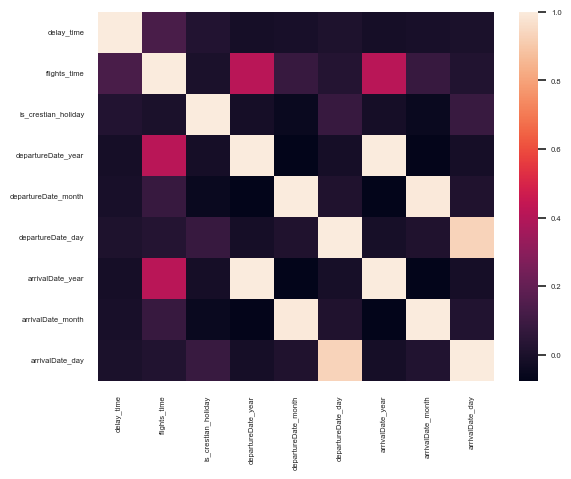

In [470]:
sns.heatmap(flights_df.corr())

we can see that there is no correlation between out columns to flight delay.
We thing that if we change out date presentation we maby can see some corelation

We will use date in year instad of our current way that use 3 separate columns

## Change Date presentatuin

In [471]:
def dayes_in_month(month,year):
    return calendar.monthrange(year, month)[1]

In [472]:
def get_day_in_year(year,mnt : pd.Series,day):
    daysList = []
    for i,x in enumerate(mnt.tolist()):
        days=0
        y = year.tolist()[i]
        for m in range(1,mnt.tolist()[i]):
            days = days + dayes_in_month(m,y)
        days = days + day.tolist()[i]
        daysList.append(days)
    return pd.Series(daysList)



In [473]:
def convert_days_columns_to_day_in_year(df,col):
    df[col + '_day_in_year'] = get_day_in_year(df[col+'_year'],df[col+'_month'],df[col+'_day'])

    df = df.drop(col+'_month',axis = 1)
    df = df.drop(col+'_day',axis = 1)

    return df

In [474]:
def convert_all_days_columns_to_day_in_year(df):
    df = convert_days_columns_to_day_in_year(df,'departureDate')
    df = convert_days_columns_to_day_in_year(df,'arrivalDate')
    return df

In [475]:
flights_df = convert_all_days_columns_to_day_in_year(flights_df)

Now we check if there is any correlation

<AxesSubplot:>

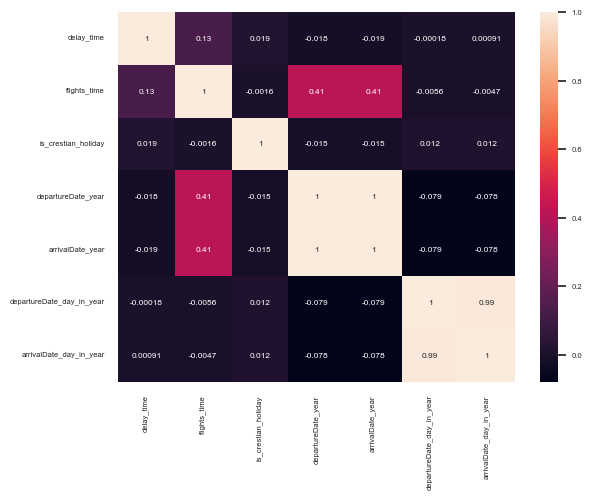

In [476]:
sns.heatmap(flights_df.corr(),annot=True)

# Data Visualization

Scatter plot

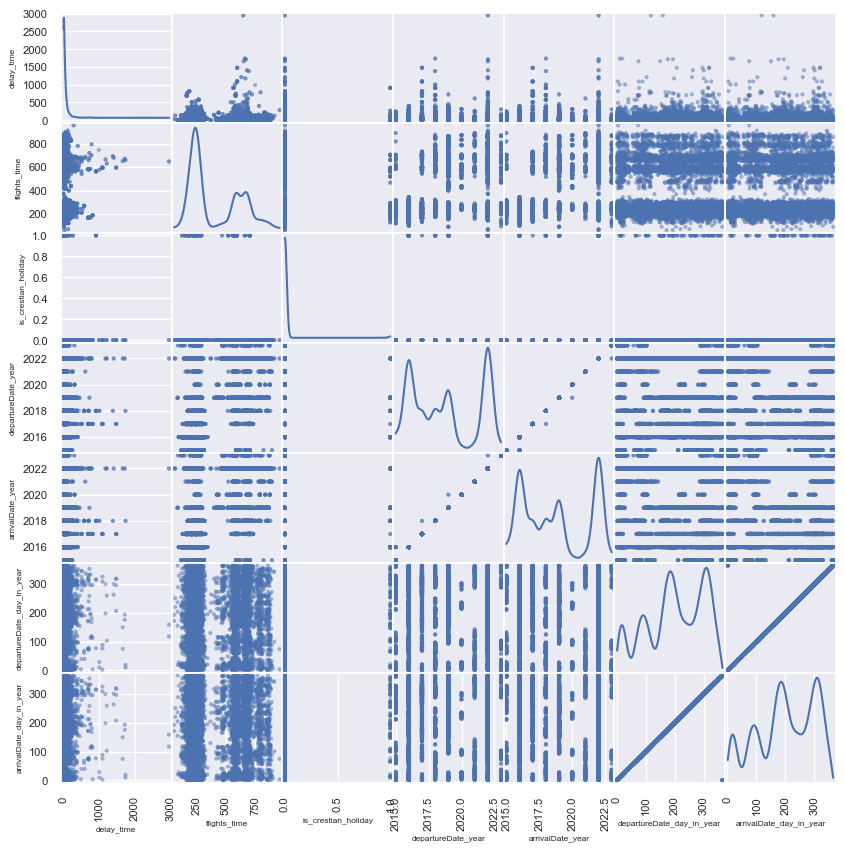

In [477]:
pd.plotting.scatter_matrix(flights_df, figsize=(10, 10), diagonal='kde')
plt.show()

## FLights count per year

<AxesSubplot:xlabel='departureDate_year', ylabel='count'>

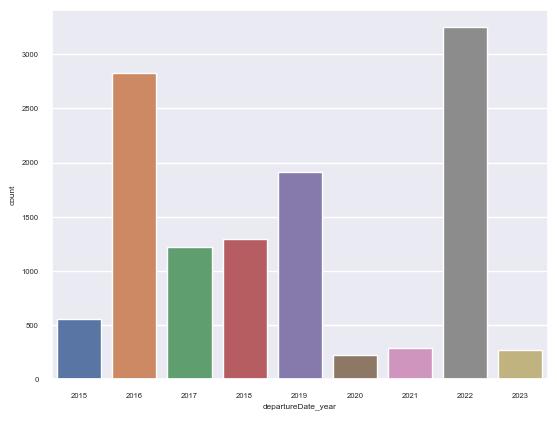

In [478]:
sns.countplot(data = flights_df , x='departureDate_year')

we can see that in 2020 and 2021 the number of flights was segnificantly lower then other years,
we can guess that happend due to covid 19 pandemics.
To avoid this pandemic from affect out model we will drop data from thouse years.

## Flights count per aircraft

<AxesSubplot:xlabel='tailnumber', ylabel='count'>

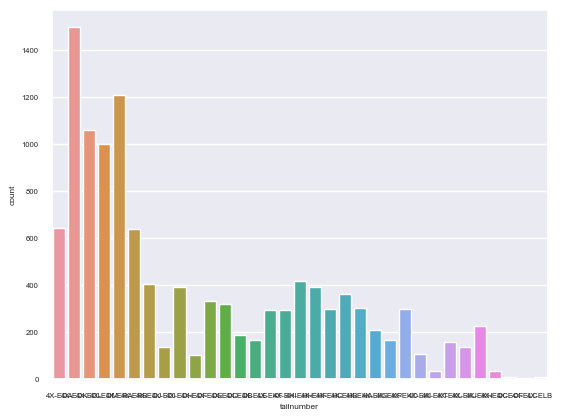

In [479]:
sns.set(font_scale=0.5)
sns.countplot(data = flights_df , x='tailnumber')

## Delay time per aircraft

<AxesSubplot:xlabel='tailnumber', ylabel='delay_time'>

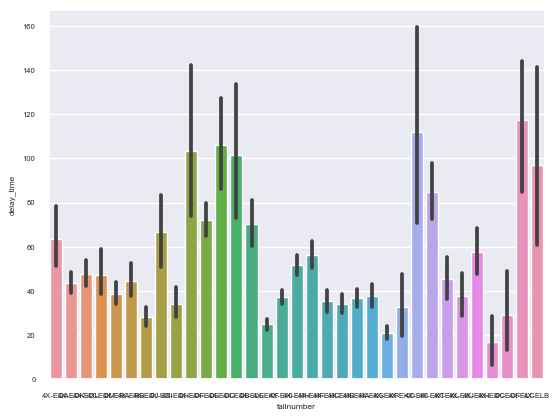

In [480]:
sns.barplot(data = flights_df,x = 'tailnumber', y = 'delay_time')

## Avarage delay time per year

<AxesSubplot:xlabel='departureDate_year', ylabel='delay_time'>

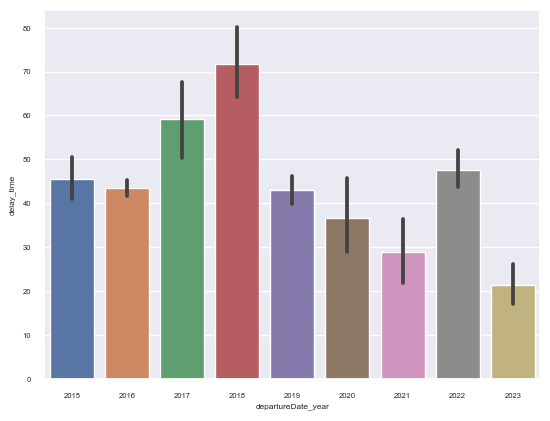

In [481]:
sns.barplot(data = flights_df , x='departureDate_year',y='delay_time')

## Delays per day in the year

We want to see if there is some connection between the day in the year and the delay time

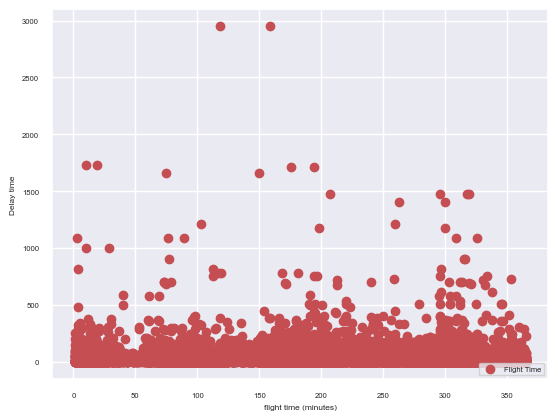

In [482]:
plt.scatter(x=flights_df['departureDate_day_in_year'],y=flights_df['delay_time'],c='r',label='Flight Time')
#plt.scatter(x=flights_df['Newspaper'],y=flights_df['delay_time'],c='k',marker='*',label='')
plt.legend(numpoints=1,loc=4)
plt.xlabel('flight time (minutes)')
plt.ylabel('Delay time')
plt.show()

# Convert categprial values to binaruies

In [483]:
def convert_categorials_to_bin(df , cols):
    return pd.get_dummies( df,columns= cols)

In [484]:
flights_df = convert_categorials_to_bin(flights_df,['departureAirportFsCode','arrivalAirportFsCode','tailnumber','aircraft_model','departureTerminal','arrivalTerminal'])

# Manage outlayers


In [485]:
flights_df.describe()

,delay_time,flights_time,is_crestian_holiday,departureDate_year,arrivalDate_year,departureDate_day_in_year,arrivalDate_day_in_year,departureAirportFsCode_AGP,departureAirportFsCode_AMS,departureAirportFsCode_ATH,...,arrivalTerminal_PVG_2,arrivalTerminal_SFO_INTL,arrivalTerminal_SOF_2,arrivalTerminal_SOF_T2,arrivalTerminal_SXF_A,arrivalTerminal_TAS_2,arrivalTerminal_TLV_3,arrivalTerminal_TLV_T3,arrivalTerminal_VLC_1,arrivalTerminal_YYZ_3
count,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,9033.000000,9033.000000,11846.000000,11846.000000,11846.000000,...,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000
mean,48.332686,394.641063,0.013253,2018.763296,2018.764562,193.562272,193.434629,0.000422,0.020767,0.000591,...,0.000338,0.002195,0.004812,0.001182,0.000422,0.000169,0.510299,0.003546,0.000422,0.020176
std,108.009176,210.571128,0.114363,2.513287,2.512516,104.686817,104.750990,0.020541,0.142608,0.024303,...,0.018373,0.046800,0.069203,0.034359,0.020541,0.012993,0.499915,0.059441,0.020541,0.140607
min,0.000000,62.000000,0.000000,2015.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,230.000000,0.000000,2016.000000,2016.000000,104.000000,104.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,271.000000,0.000000,2019.000000,2019.000000,196.000000,196.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,53.000000,596.000000,0.000000,2022.000000,2022.000000,291.000000,291.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2951.000000,956.000000,1.000000,2023.000000,2023.000000,365.000000,365.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Build liniar regresion model

In [492]:
X_fit = flights_df.drop('delay_time',axis=1)
y_fit = flights_df.delay_time
model = linear_model.LinearRegression()
fitted_model = model.fit(X=X_fit,y=y_fit)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').